# Phase 2

- More information - Phase 0 (Business Requirement) and Phase 1 (EDA using Python)

#### Exploratory Data Analysis (EDA) - customer support  +

#### Deep investigation to identify why and which characteristics led the customers to churn



#### Dataset
the dataset used in this process can be accessed trought IBM website below

https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/


In [1]:
## Load libraries used in the process
library(tidyverse)
library(caret)
library(xgboost)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.0.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift


Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice



In [2]:
## Load the Dataset - Customer Churn
df <- read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
head(df, 5)

Parsed with column specification:
cols(
  .default = col_character(),
  SeniorCitizen = col_integer(),
  tenure = col_integer(),
  MonthlyCharges = col_double(),
  TotalCharges = col_double()
)
See spec(...) for full column specifications.


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Info
- One dataset related to a telco customer can have hundreds, sometimes thousand of features to analyse
- To keep the process simple it is going to be used the top 5 features from Phase 1 + gender to add some context of analysis
- - you will see later in this notebook that this 6 features will become 46 features to be analysed

In [3]:
## Exclude Customer_ID and apply 0 to Total Charges -> First Bill
df[is.na(df$TotalCharges) & df$tenure==0 , ]['TotalCharges'] <- 0
df$customerID <- NULL

target <- 'Churn'
feature_categories <- df %>% keep(is.character) %>% colnames()
feature_categories <- setdiff(feature_categories, target)

## converte character to factor for analysis
df <- df %>%  mutate_if(is.character, as.factor)

current_features <- c('tenure', 'MonthlyCharges', 'TotalCharges', 'gender', 'PaymentMethod' , 'Churn', 'Contract')
summary(df[current_features])


     tenure      MonthlyCharges    TotalCharges       gender    
 Min.   : 0.00   Min.   : 18.25   Min.   :   0.0   Female:3488  
 1st Qu.: 9.00   1st Qu.: 35.50   1st Qu.: 398.6   Male  :3555  
 Median :29.00   Median : 70.35   Median :1394.5                
 Mean   :32.37   Mean   : 64.76   Mean   :2279.7                
 3rd Qu.:55.00   3rd Qu.: 89.85   3rd Qu.:3786.6                
 Max.   :72.00   Max.   :118.75   Max.   :8684.8                
                   PaymentMethod  Churn                Contract   
 Bank transfer (automatic):1544   No :5174   Month-to-month:3875  
 Credit card (automatic)  :1522   Yes:1869   One year      :1473  
 Electronic check         :2365              Two year      :1695  
 Mailed check             :1612                                   
                                                                  
                                                                  

## Analyse charges and churn by gender

#### Info
- The Monthly Charge, Total Charges and churn(yes/no) is well distributed between gender as showed by graphic below

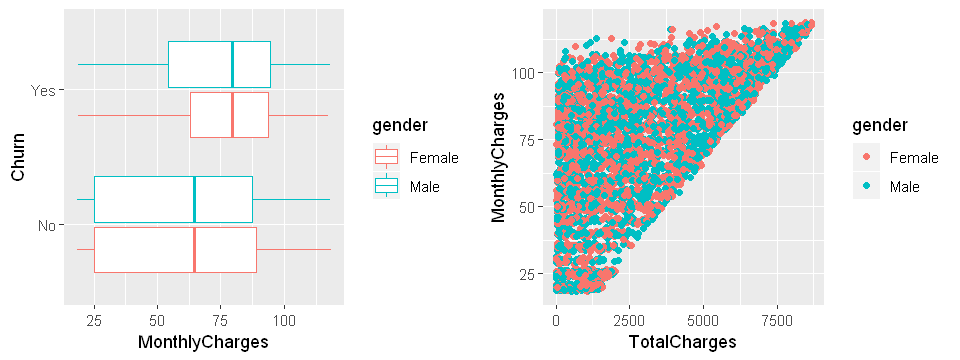

In [4]:
options(repr.plot.width = 8, repr.plot.height = 3)
gg1 <- qplot(data=df, x=Churn, y=MonthlyCharges, color=gender, geom='boxplot') + coord_flip()
gg2 <- qplot(data=df, x=TotalCharges, y=MonthlyCharges, color=gender, geom='point')
# gg3 <- qplot(data=df, x=TotalCharges, y=MonthlyCharges, color=Churn, geom='point')

gridExtra::grid.arrange(gg1, gg2, nrow = 1)

## Analyse the Payment Method and Charges associated with Churn (Yes or No)

#### Note
- The Payment Method (Eletronick check: biggest one) have quite the same proportion of Churn (Yes or No)
    seems to not influence a lot. 
- Other types of payments can influence the customer churn but have less customers associated with it
    

## 1st Insight
- The first important insight is the confirmation of a lot of Churners caused by Monthly Charges without correlation high Total Charges
- Note that high Total Charges do not have so many churners also

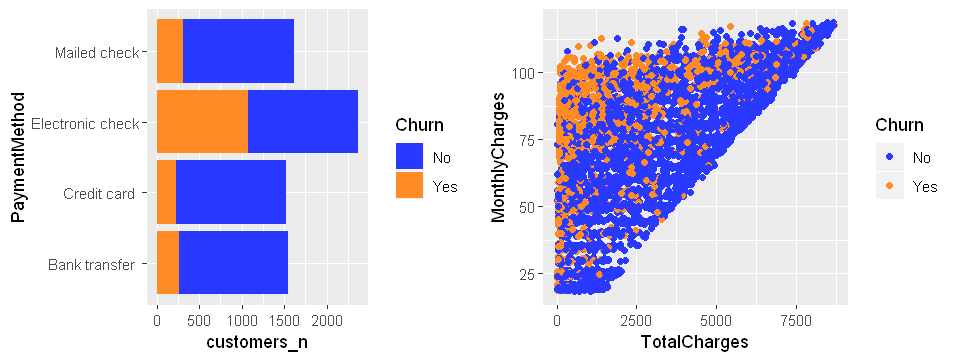

In [5]:
## Payment Method
pmnt <-  df %>% group_by(PaymentMethod, Churn) %>% summarise(customers_n = n())
pmnt$PaymentMethod <-  str_remove(str_remove(str_remove(pmnt$PaymentMethod, 'automatic'), '\\('), '\\)')


## plot de 4 graficos em conjunto
color_manual <- c('#2a39ff', '#ff8b24')

gg3 <- qplot(data=df, x=TotalCharges, y=MonthlyCharges, color=Churn, geom='point')
gg3 <- gg3 + scale_color_manual(values=color_manual)
gg4 <- qplot(data = pmnt, x= PaymentMethod , y=customers_n, fill=Churn,  geom='col') + coord_flip()
gg4 <- gg4 + scale_fill_manual(values=color_manual)


gridExtra::grid.arrange(gg4, gg3, nrow = 1)


## Investigate monthly charges by contract type, by tenure and churners

#### Note
- The customer churners are not well distibuted between contract type
- Long term contracts such as Two years and also One Year have much less churners
    

## 2nd Insight
- The higher volume of churners are associated with Month-to-Month Contract with high Monthly Charges and usually small tenure

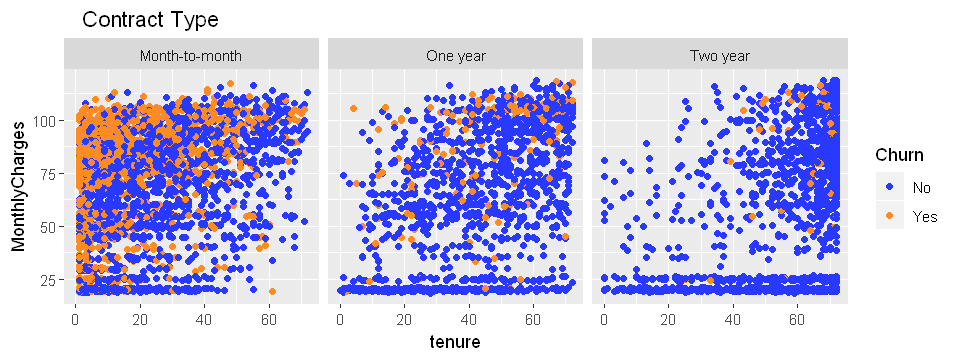

In [6]:
## Contract and tenure drives to Churn
gg5 <- qplot(data=df, x=tenure, y=MonthlyCharges, color=Churn, geom='point', facets = .~Contract, main='   Contract Type')
gg5 <- gg5 + scale_color_manual(values=color_manual)

gridExtra::grid.arrange(gg5, nrow = 1)

### Let´s run one machine learning algorithm to identify the relationship in the data


- Run xgboost model and plot the feature importance 
- - the idea here is also to improve the model accuracy achieved with Random Forest in Phase 1
    
    
- One trick: use of One Hot Encoding and not the Label Encoding used Phase 1
- - the target with this trick is to see the detailed features that drives customers to churn
- - and also to confirm if the analyse above can be susteined by the machine learning model

In [7]:
## few steps before run the xgb model

target <- 'Churn'
feature_categories <- df %>% keep(is.factor) %>% colnames()
feature_categories <- setdiff(feature_categories, target)

## function to run the One Hot Enconding -> all features categories 
ffm_One_Hot_Encoding_dataframe <- function(dataframe, cols_OneHOtEncoding=c()){
  # ONE HOT ENCODING --------------------------------------------------------
  require(caret)  
  
  for (i in seq_along(cols_OneHOtEncoding)){
    idx_col <- which(colnames(dataframe) == cols_OneHOtEncoding[i])
    formula <- as.formula( paste0('~ ' , cols_OneHOtEncoding[i]))    
    dummies <- predict(dummyVars(formula, data = dataframe), newdata = dataframe)
    dataframe <- cbind(dataframe, dummies)
    dataframe[, idx_col] <- NULL
  }
  return(dataframe)  
}

df_xgb <- ffm_One_Hot_Encoding_dataframe(df, feature_categories)

df_xgb$Churn <- as.integer(as.factor(df_xgb$Churn)) -1L

## Dataframe structure
## str(df)

#### The shape of the dataset/telco customer to be analysed have now 46 features

In [8]:
dim(df_xgb)[2]

[1] 46

## Execution of the machine learning model

In [9]:
## Finally let's run the model
## 

set.seed(458)
idx <- createDataPartition(df_xgb$Churn, p=0.80, list = FALSE)
train <- df_xgb[idx, ]
test <- df_xgb[-idx, ]
idx_target <- which(colnames(df_xgb)==target)

dtrain <- xgb.DMatrix(as.matrix(train[, -idx_target]), label=train[[target]])
dtest <-  xgb.DMatrix(as.matrix(test[, -idx_target]), label=test[[target]])


parameters <- list(objective = "binary:logistic", 
                   eval_metric = "auc")

nrounds_xgb <- 100
set.seed(458)
fit.xgb <- xgb.train(params = parameters,
                     data = dtrain,
                     watchlist = list(train = dtrain, eval = dtest),
                     early_stopping_rounds = 5,
                     nrounds = nrounds_xgb,
                     print_every_n = 10,
                     nthread = 2)


xgb_predict <- predict(fit.xgb, as.matrix(test[, -idx_target]))
xgb_predict <- round(xgb_predict)

confusionMatrix(factor(xgb_predict), factor(test$Churn), positive = '1')


[1]	train-auc:0.859149	eval-auc:0.828259 
Multiple eval metrics are present. Will use eval_auc for early stopping.
Will train until eval_auc hasn't improved in 5 rounds.

[11]	train-auc:0.903985	eval-auc:0.841185 
Stopping. Best iteration:
[15]	train-auc:0.910813	eval-auc:0.842038



Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 912 161
         1 118 217
                                          
               Accuracy : 0.8018          
                 95% CI : (0.7801, 0.8224)
    No Information Rate : 0.7315          
    P-Value [Acc > NIR] : 5.033e-10       
                                          
                  Kappa : 0.4767          
 Mcnemar's Test P-Value : 0.01192         
                                          
            Sensitivity : 0.5741          
            Specificity : 0.8854          
         Pos Pred Value : 0.6478          
         Neg Pred Value : 0.8500          
             Prevalence : 0.2685          
         Detection Rate : 0.1541          
   Detection Prevalence : 0.2379          
      Balanced Accuracy : 0.7298          
                                          
       'Positive' Class : 1               
                                          

## Improvement of 3% of accuracy with xgboost

- The accuracy now is 80.18% instead of 77% (Phase 1 with Random Forest)

#### Save / store the xgb model (accuracy of 80 percent)

In [10]:
## Save the model -> 80% of accuracy
xgb.save(fit.xgb, '../data/xgb_model_acc_80p.model')

## obs. to load the model later just run the command below
## model_xgb <- xgb.load('./data/xgb_model_acc_80p.model')

[1] TRUE

## Plot of feature importance

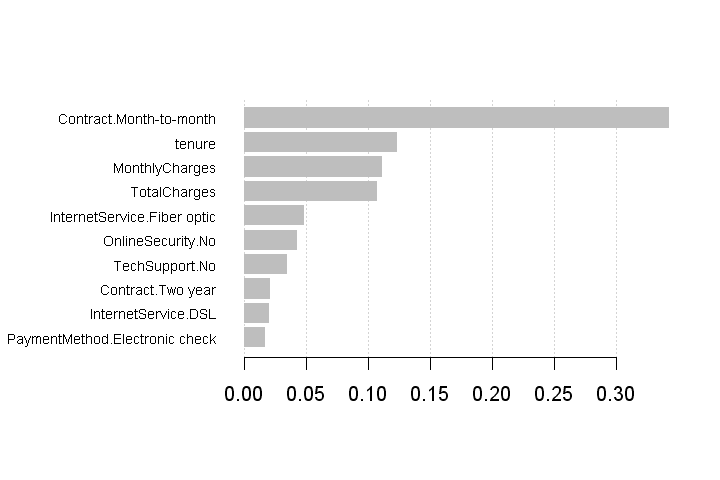

In [11]:
## importance matrix
importance_matrix <- xgb.importance(colnames(dtrain), 
                                    model = fit.xgb)

options(repr.plot.width = 6, repr.plot.height = 4)
xgb.plot.importance(importance_matrix, top_n = 10)


## 3rd Insight

- Contract type is really important and Month to Month contract is the most important feature along wiht tenure and monthly charges


- Note that the most important feature related to payment method (eletronic check) are just the top 10

### Evaluate the distribution of churners by contract type

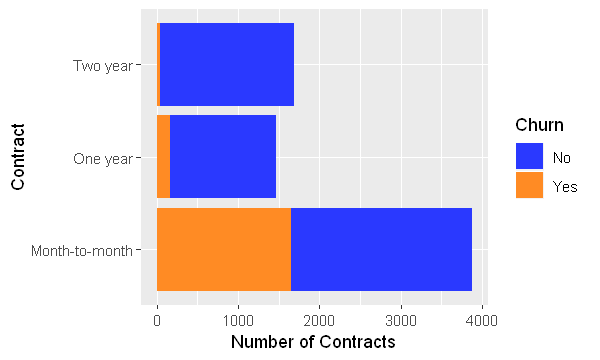

In [12]:
options(repr.plot.width = 5, repr.plot.height = 3)
gg6 <- qplot(data=df, Contract, fill=Churn, ylab='Number of Contracts') + coord_flip()
gg6 <- gg6 + scale_fill_manual(values=color_manual)

print(gg6)

## How much revenue will be lost by contract type ? 

- May be the charges are quite similar between contract type and tenure ... let's see...

#### Revenue stopped because the customer churn

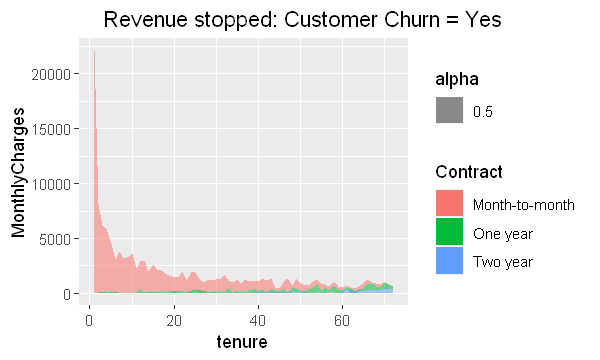

In [15]:
df %>% filter(Churn=='Yes') %>%   
  group_by(tenure, Contract) %>% 
  summarise( MonthlyCharges=sum(MonthlyCharges), 
             TotalCharges=sum(TotalCharges))  %>% 
  qplot(data=. ,x=tenure, y=MonthlyCharges, 
        geom='area', alpha=0.5, fill=Contract,
        main='    Revenue stopped: Customer Churn = Yes') 

# Summary

### The top 3 most important features related to churn (Yes) are:

- Higher Monthly Charges
- Small to Medium Tenure and associated with
- Month-to-Month contract

##### Well done... better clear picture of why customers churn

- Next notebooks will use python to build machine learning models and apply additional techniques to improve performance